# Spike Plotting

Brief 1-2 sentence description of notebook.

In [1]:
import glob
import re
import os

In [2]:
# Imports of all used packages and libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Inputs & Data

Explanation of each input and where it comes from.

In [3]:
# Inputs and Required data loading
# input varaible names are in all caps snake case
# Whenever an input changes or is used for processing 
# the vairables are all lower in snake case

TRIAL_LENGTH = 10
SAMPLING_RATE = 20000
TONE_TIMESTAMP_DF = pd.read_excel("../../rce_tone_timestamp.xlsx", index_col=0)
OUTPUT_DIR = r"./proc" # where data is saved should always be shown in the inputs

INPUT_DIR=glob.glob("/scratch/back_up/reward_competition_extention/proc/phy_curation/*")

In [4]:
TRIAL_NUMBER_COL = "trial_number"

## Outputs

Describe each output that the notebook creates. 

- Is it a plot or is it data?

- How valuable is the output and why is it valuable or useful?

## Processing

Describe what is done to the data here and how inputs are manipulated to generate outputs. 

In [5]:
# As much code and as many cells as required
# includes EDA and playing with data
# GO HAM!

# Ideally functions are defined here first and then data is processed using the functions

# function names are short and in snake case all lowercase
# a function name should be unique but does not have to describe the function
# doc strings describe functions not function names

def calc_bmi(weight, height):
    """
    This is a function that calculates BMI.
    it uses height and weight...etc.
    Meghan plz show us your docsctring format here.
    """
    bmi = weight/(height**2)
    return(bmi)


In [6]:
def find_closest(target, reference_list):
    """
    Finds the closest number in a reference list to the given target number.

    Parameters:
    - target (float or int): The number for which we want to find the closest value.
    - reference_list (list of float or int): The list of numbers in which we want to search.

    Returns:
    - float or int: The closest number from the reference list to the target.
    """

    # Using the 'min' function with a custom key to determine the closest value by minimal absolute difference
    closest_value = min(reference_list, key=lambda x: abs(x - target))
    
    return closest_value

In [7]:
def find_index_in_group(group, value_column, new_column_name):
    unique_values = sorted(list(set(group[value_column])))
    group[new_column_name] = group[value_column].apply(lambda x: unique_values.index(x) + 1)
    return group

### Getting the subject IDs from the file name

- Dropping all unlabeled trials

In [8]:
all_trials_df = TONE_TIMESTAMP_DF.dropna(subset="condition").sort_values(by=["recording_file", "time_stamp_index"]).reset_index(drop=True)

- Making sure that all timestamps are integers

In [9]:
all_trials_df["time"] = all_trials_df["time"].astype(int)
all_trials_df["time_stamp_index"] = all_trials_df["time_stamp_index"].astype(int)
all_trials_df["video_frame"] = all_trials_df["video_frame"].astype(int)

In [10]:
all_trials_df.head()

,time,state,recording_dir,recording_file,din,time_stamp_index,video_file,video_frame,video_number,subject_info,condition,competition_closeness,Unnamed: 13
0,6310663,1.0,20221202_134600_omission_and_competition_subje...,20221202_134600_omission_and_competition_subje...,dio_ECU_Din1,1390826,20221202_134600_omission_and_competition_subje...,1734,1.0,6_1_top_2_base_3,rewarded,NaN,NaN
1,7910662,1.0,20221202_134600_omission_and_competition_subje...,20221202_134600_omission_and_competition_subje...,dio_ECU_Din1,2990825,20221202_134600_omission_and_competition_subje...,3728,1.0,6_1_top_2_base_3,rewarded,NaN,NaN
2,9710660,1.0,20221202_134600_omission_and_competition_subje...,20221202_134600_omission_and_competition_subje...,dio_ECU_Din1,4790823,20221202_134600_omission_and_competition_subje...,5972,1.0,6_1_top_2_base_3,rewarded,NaN,NaN
3,11310658,1.0,20221202_134600_omission_and_competition_subje...,20221202_134600_omission_and_competition_subje...,dio_ECU_Din1,6390821,20221202_134600_omission_and_competition_subje...,7966,1.0,6_1_top_2_base_3,omission,NaN,NaN
4,12810657,1.0,20221202_134600_omission_and_competition_subje...,20221202_134600_omission_and_competition_subje...,dio_ECU_Din1,7890820,20221202_134600_omission_and_competition_subje...,9836,1.0,6_1_top_2_base_3,rewarded,NaN,NaN


- Original timestamps are based on ephys recordings at 20kHz. The LFP will be at 1kHz, so we will need to divide all the timestamps by 20

In [11]:
all_trials_df["resampled_index"] = all_trials_df["time_stamp_index"] // 20

In [12]:
all_trials_df["recording_dir"].unique()

array(['20221202_134600_omission_and_competition_subject_6_1_and_6_2',
       '20221203_154800_omission_and_competition_subject_6_4_and_6_1',
       '20221214_125409_om_and_comp_6_1_and_6_3',
       '20221215_145401_comp_amd_om_6_1_and_6_3',
       '20230612_101430_standard_comp_to_training_D1_subj_1-4_and_1-3',
       '20230617_115521_standard_comp_to_omission_D1_subj_1-1_and_1-2',
       '20230618_100636_standard_comp_to_omission_D2_subj_1-4_and_1-1',
       '20230619_115321_standard_comp_to_omission_D3_subj_1-2_and_1-4',
       '20230620_114347_standard_comp_to_omission_D4_subj_1-2_and_1-1',
       '20230621_111240_standard_comp_to_omission_D5_subj_1-4_and_1-2'],
      dtype=object)

- Getting a list of all the subjects through the recording name

In [13]:
all_trials_df["all_subjects"] = all_trials_df["recording_dir"].apply(lambda x: ["{}.{}".format(tup[0],tup[1]) for tup in re.findall(r'(\d+)-(\d+)', x.replace("_", "-"))[1:]])

In [14]:
all_trials_df["all_subjects"].head()

0    [6.1, 6.2]
1    [6.1, 6.2]
2    [6.1, 6.2]
3    [6.1, 6.2]
4    [6.1, 6.2]
Name: all_subjects, dtype: object

- Getting the current subject of the recording through the ending of the recording name file

In [15]:
all_trials_df["subject_info"].head()

0    6_1_top_2_base_3
1    6_1_top_2_base_3
2    6_1_top_2_base_3
3    6_1_top_2_base_3
4    6_1_top_2_base_3
Name: subject_info, dtype: object

In [16]:
all_trials_df["current_subject"] = all_trials_df["subject_info"].apply(lambda x: ".".join(x.replace("-","_").split("_")[:2]))

In [17]:
all_trials_df.head()

,time,state,recording_dir,recording_file,din,time_stamp_index,video_file,video_frame,video_number,subject_info,condition,competition_closeness,Unnamed: 13,resampled_index,all_subjects,current_subject
0,6310663,1.0,20221202_134600_omission_and_competition_subje...,20221202_134600_omission_and_competition_subje...,dio_ECU_Din1,1390826,20221202_134600_omission_and_competition_subje...,1734,1.0,6_1_top_2_base_3,rewarded,NaN,NaN,69541,"[6.1, 6.2]",6.1
1,7910662,1.0,20221202_134600_omission_and_competition_subje...,20221202_134600_omission_and_competition_subje...,dio_ECU_Din1,2990825,20221202_134600_omission_and_competition_subje...,3728,1.0,6_1_top_2_base_3,rewarded,NaN,NaN,149541,"[6.1, 6.2]",6.1
2,9710660,1.0,20221202_134600_omission_and_competition_subje...,20221202_134600_omission_and_competition_subje...,dio_ECU_Din1,4790823,20221202_134600_omission_and_competition_subje...,5972,1.0,6_1_top_2_base_3,rewarded,NaN,NaN,239541,"[6.1, 6.2]",6.1
3,11310658,1.0,20221202_134600_omission_and_competition_subje...,20221202_134600_omission_and_competition_subje...,dio_ECU_Din1,6390821,20221202_134600_omission_and_competition_subje...,7966,1.0,6_1_top_2_base_3,omission,NaN,NaN,319541,"[6.1, 6.2]",6.1
4,12810657,1.0,20221202_134600_omission_and_competition_subje...,20221202_134600_omission_and_competition_subje...,dio_ECU_Din1,7890820,20221202_134600_omission_and_competition_subje...,9836,1.0,6_1_top_2_base_3,rewarded,NaN,NaN,394541,"[6.1, 6.2]",6.1


- Labeling the trial as a winner or loser if the winner matches the subject id or not

In [18]:
all_trials_df["trial_outcome"] = all_trials_df.apply(
    lambda x: "win" if str(x["condition"]).strip() == str(x["current_subject"]) 
             else ("lose" if str(x["condition"]) in x["all_subjects"] 
                   else x["condition"]), axis=1)

In [19]:
all_trials_df.head()

,time,state,recording_dir,recording_file,din,time_stamp_index,video_file,video_frame,video_number,subject_info,condition,competition_closeness,Unnamed: 13,resampled_index,all_subjects,current_subject,trial_outcome
0,6310663,1.0,20221202_134600_omission_and_competition_subje...,20221202_134600_omission_and_competition_subje...,dio_ECU_Din1,1390826,20221202_134600_omission_and_competition_subje...,1734,1.0,6_1_top_2_base_3,rewarded,NaN,NaN,69541,"[6.1, 6.2]",6.1,rewarded
1,7910662,1.0,20221202_134600_omission_and_competition_subje...,20221202_134600_omission_and_competition_subje...,dio_ECU_Din1,2990825,20221202_134600_omission_and_competition_subje...,3728,1.0,6_1_top_2_base_3,rewarded,NaN,NaN,149541,"[6.1, 6.2]",6.1,rewarded
2,9710660,1.0,20221202_134600_omission_and_competition_subje...,20221202_134600_omission_and_competition_subje...,dio_ECU_Din1,4790823,20221202_134600_omission_and_competition_subje...,5972,1.0,6_1_top_2_base_3,rewarded,NaN,NaN,239541,"[6.1, 6.2]",6.1,rewarded
3,11310658,1.0,20221202_134600_omission_and_competition_subje...,20221202_134600_omission_and_competition_subje...,dio_ECU_Din1,6390821,20221202_134600_omission_and_competition_subje...,7966,1.0,6_1_top_2_base_3,omission,NaN,NaN,319541,"[6.1, 6.2]",6.1,omission
4,12810657,1.0,20221202_134600_omission_and_competition_subje...,20221202_134600_omission_and_competition_subje...,dio_ECU_Din1,7890820,20221202_134600_omission_and_competition_subje...,9836,1.0,6_1_top_2_base_3,rewarded,NaN,NaN,394541,"[6.1, 6.2]",6.1,rewarded


# Reading in Phy

- Reading in a spreadsheet of all the unit classifications
    - They are divided up into good units, multi-units, and noise

In [20]:
INPUT_DIR

['/scratch/back_up/reward_competition_extention/proc/phy_curation/tbc',
 '/scratch/back_up/reward_competition_extention/proc/phy_curation/20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged.rec',
 '/scratch/back_up/reward_competition_extention/proc/phy_curation/20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged.rec',
 '/scratch/back_up/reward_competition_extention/proc/phy_curation/20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged.rec']

In [21]:
recording_to_cluster_info = {}
for recording_dir in INPUT_DIR:
    try:
        recording_basename = os.path.basename(recording_dir).strip(".rec")
        file_path = os.path.join(recording_dir, "phy", "cluster_info.tsv")
        recording_to_cluster_info[recording_basename] = pd.read_csv(file_path, sep="\t")
    except Exception as e:
        print(e)

[Errno 2] No such file or directory: '/scratch/back_up/reward_competition_extention/proc/phy_curation/tbc/phy/cluster_info.tsv'


In [22]:
recording_to_cluster_info[list(recording_to_cluster_info.keys())[0]]

,cluster_id,1_5_ms_isi,1ms_isi,2ms_isi,amp,ch,channel_group,depth,fr,group,n_spikes,sh,si_unit_id
0,2,0,0,0,24.692951,1,0.0,20.0,1.070175,good,3658,0,3.0
1,3,235,106,472,10.347874,1,0.0,20.0,14.493880,mua,49542,0,4.0
2,4,64,25,149,11.953332,4,0.0,80.0,27.163371,mua,92848,0,5.0
3,10,69,29,194,10.297276,18,0.0,360.0,6.455279,mua,22065,0,12.0
4,11,619,261,1295,9.638424,19,0.0,380.0,18.195901,mua,62196,0,13.0
5,17,65,37,141,10.680766,24,0.0,480.0,6.339427,mua,21669,0,19.0
6,18,3,0,21,13.899227,24,0.0,480.0,3.850641,mua,13162,0,20.0
7,20,0,0,0,19.467382,11,0.0,220.0,0.739585,good,2528,0,7.0
8,21,0,0,0,19.467382,11,0.0,220.0,0.078698,mua,269,0,7.0
9,22,0,0,0,21.967876,13,0.0,260.0,0.465459,good,1591,0,8.0


- Combining all the unit info dataframes and adding the recording name

In [23]:
recording_to_cluster_info_df = pd.concat(recording_to_cluster_info, names=['recording_name']).reset_index(level=1, drop=True).reset_index()


In [24]:
recording_to_cluster_info_df.head()

,recording_name,cluster_id,1_5_ms_isi,1ms_isi,2ms_isi,amp,ch,channel_group,depth,fr,group,n_spikes,sh,si_unit_id
0,20230620_114347_standard_comp_to_omission_D4_s...,2,0,0,0,24.692951,1,0.0,20.0,1.070175,good,3658,0,3.0
1,20230620_114347_standard_comp_to_omission_D4_s...,3,235,106,472,10.347874,1,0.0,20.0,14.493880,mua,49542,0,4.0
2,20230620_114347_standard_comp_to_omission_D4_s...,4,64,25,149,11.953332,4,0.0,80.0,27.163371,mua,92848,0,5.0
3,20230620_114347_standard_comp_to_omission_D4_s...,10,69,29,194,10.297276,18,0.0,360.0,6.455279,mua,22065,0,12.0
4,20230620_114347_standard_comp_to_omission_D4_s...,11,619,261,1295,9.638424,19,0.0,380.0,18.195901,mua,62196,0,13.0


- Filtering for the good units

In [25]:
good_unit_cluster_info_df = recording_to_cluster_info_df[recording_to_cluster_info_df["group"] == "good"].reset_index(drop=True)

In [26]:
good_unit_cluster_info_df.head()

,recording_name,cluster_id,1_5_ms_isi,1ms_isi,2ms_isi,amp,ch,channel_group,depth,fr,group,n_spikes,sh,si_unit_id
0,20230620_114347_standard_comp_to_omission_D4_s...,2,0,0,0,24.692951,1,0.0,20.0,1.070175,good,3658,0,3.0
1,20230620_114347_standard_comp_to_omission_D4_s...,20,0,0,0,19.467382,11,0.0,220.0,0.739585,good,2528,0,7.0
2,20230620_114347_standard_comp_to_omission_D4_s...,22,0,0,0,21.967876,13,0.0,260.0,0.465459,good,1591,0,8.0
3,20230620_114347_standard_comp_to_omission_D4_s...,34,0,0,0,23.960157,22,0.0,440.0,0.402266,good,1375,0,17.0
4,20230620_114347_standard_comp_to_omission_D4_s...,57,2,0,7,22.906088,0,NaN,0.0,2.406577,good,8226,0,NaN


In [27]:
recording_to_good_unit_ids = good_unit_cluster_info_df.groupby('recording_name')['cluster_id'].apply(list).to_dict()


- A list of all the unit IDs that each spike came from in order
    - First item is first spike, second item is second spike, etc.

In [28]:
recording_to_spike_clusters = {}
for recording_dir in INPUT_DIR:
    try:
        recording_basename = os.path.basename(recording_dir).strip(".rec")
        file_path = os.path.join(recording_dir, "phy", "spike_clusters.npy")
        recording_to_spike_clusters[recording_basename] = np.load(file_path)
    except Exception as e:
        print(e)

[Errno 2] No such file or directory: '/scratch/back_up/reward_competition_extention/proc/phy_curation/tbc/phy/spike_clusters.npy'


In [29]:
recording_to_spike_clusters[list(recording_to_spike_clusters.keys())[0]]

array([ 4,  4, 11, ...,  4,  4, 87], dtype=int32)

In [30]:
recording_to_spike_clusters[list(recording_to_spike_clusters.keys())[0]].shape

(487318,)

- The times that all the spikes happened

In [31]:
recording_to_spike_times = {}
for recording_dir in INPUT_DIR:
    try:
        recording_basename = os.path.basename(recording_dir).strip(".rec")
        file_path = os.path.join(recording_dir, "phy", "spike_times.npy")
        recording_to_spike_times[recording_basename] = np.load(file_path)
    except Exception as e:
        print(e)

[Errno 2] No such file or directory: '/scratch/back_up/reward_competition_extention/proc/phy_curation/tbc/phy/spike_times.npy'


In [32]:
recording_to_spike_times[list(recording_to_spike_times.keys())[0]]

array([[     160],
       [     483],
       [     503],
       ...,
       [68361973],
       [68362204],
       [68362381]])

In [33]:
recording_to_spike_times[list(recording_to_spike_times.keys())[0]].shape

(487318, 1)

### Combining everything into a dataframe

In [34]:
recording_to_spike_df = {}
for recording_dir in INPUT_DIR:
    try:
        recording_basename = os.path.basename(recording_dir).strip(".rec")
        cluster_info_path = os.path.join(recording_dir, "phy", "cluster_info.tsv")
        cluster_info_df = pd.read_csv(cluster_info_path, sep="\t")

        spike_clusters_path = os.path.join(recording_dir, "phy", "spike_clusters.npy")
        spike_clusters = np.load(spike_clusters_path)
        
        spike_times_path = os.path.join(recording_dir, "phy", "spike_times.npy")
        spike_times = np.load(spike_times_path)

        spike_df = pd.DataFrame({'spike_clusters': spike_clusters, 'spike_times': spike_times.T[0]})

        merged_df = spike_df.merge(cluster_info_df, left_on='spike_clusters', right_on='cluster_id', how="left")
        merged_df["recording_name"] = recording_basename

        merged_df["timestamp_isi"] = merged_df.groupby('spike_clusters')["spike_times"].diff()
        merged_df["current_isi"] = merged_df["timestamp_isi"] / SAMPLING_RATE
        
        if not merged_df.empty:
            recording_to_spike_df[recording_basename] = merged_df
       
    except Exception as e:
        print(e)

[Errno 2] No such file or directory: '/scratch/back_up/reward_competition_extention/proc/phy_curation/tbc/phy/cluster_info.tsv'


- Combining the spike time df for all recordings

In [35]:
all_spike_time_df = pd.concat(recording_to_spike_df.values())

In [36]:
all_spike_time_df = all_spike_time_df[all_spike_time_df["group"] == "good"].reset_index(drop=True)

In [37]:
all_spike_time_df.head()

,spike_clusters,spike_times,cluster_id,1_5_ms_isi,1ms_isi,2ms_isi,amp,ch,channel_group,depth,fr,group,n_spikes,sh,si_unit_id,recording_name,timestamp_isi,current_isi
0,89,535,89,11,11,13,17.238409,26,0.0,520.0,15.528948,good,53080,0,21.0,20230620_114347_standard_comp_to_omission_D4_s...,NaN,NaN
1,89,1047,89,11,11,13,17.238409,26,0.0,520.0,15.528948,good,53080,0,21.0,20230620_114347_standard_comp_to_omission_D4_s...,512.0,0.02560
2,89,1384,89,11,11,13,17.238409,26,0.0,520.0,15.528948,good,53080,0,21.0,20230620_114347_standard_comp_to_omission_D4_s...,337.0,0.01685
3,89,1585,89,11,11,13,17.238409,26,0.0,520.0,15.528948,good,53080,0,21.0,20230620_114347_standard_comp_to_omission_D4_s...,201.0,0.01005
4,89,1793,89,11,11,13,17.238409,26,0.0,520.0,15.528948,good,53080,0,21.0,20230620_114347_standard_comp_to_omission_D4_s...,208.0,0.01040


In [38]:
all_spike_time_df.tail()

,spike_clusters,spike_times,cluster_id,1_5_ms_isi,1ms_isi,2ms_isi,amp,ch,channel_group,depth,fr,group,n_spikes,sh,si_unit_id,recording_name,timestamp_isi,current_isi
622770,146,38957244,146,0,0,0,14.943707,6,0.0,120.0,0.695852,good,1433,0,18.0,20230619_115321_standard_comp_to_omission_D3_s...,173.0,0.00865
622771,146,38957331,146,0,0,0,14.943707,6,0.0,120.0,0.695852,good,1433,0,18.0,20230619_115321_standard_comp_to_omission_D3_s...,87.0,0.00435
622772,204,38957511,204,1,0,1,11.366614,6,0.0,120.0,8.020020,good,16516,0,17.0,20230619_115321_standard_comp_to_omission_D3_s...,3072.0,0.15360
622773,44,38957537,44,3,1,29,9.739503,17,0.0,340.0,13.732511,good,28280,0,46.0,20230619_115321_standard_comp_to_omission_D3_s...,2342.0,0.11710
622774,134,38957868,134,5,4,17,8.562255,2,0.0,40.0,14.537135,good,29937,0,11.0,20230619_115321_standard_comp_to_omission_D3_s...,1151.0,0.05755


# Merging the trial information

- Adding a column that is the trial number

In [39]:


# Apply the function to each group and create the new column
all_trials_df = all_trials_df.groupby(["recording_file"]).apply(lambda x: find_index_in_group(x, "time", TRIAL_NUMBER_COL)).reset_index(drop="True")



In [40]:
all_trials_df.head()

,time,state,recording_dir,recording_file,din,time_stamp_index,video_file,video_frame,video_number,subject_info,condition,competition_closeness,Unnamed: 13,resampled_index,all_subjects,current_subject,trial_outcome,trial_number
0,6310663,1.0,20221202_134600_omission_and_competition_subje...,20221202_134600_omission_and_competition_subje...,dio_ECU_Din1,1390826,20221202_134600_omission_and_competition_subje...,1734,1.0,6_1_top_2_base_3,rewarded,NaN,NaN,69541,"[6.1, 6.2]",6.1,rewarded,1
1,7910662,1.0,20221202_134600_omission_and_competition_subje...,20221202_134600_omission_and_competition_subje...,dio_ECU_Din1,2990825,20221202_134600_omission_and_competition_subje...,3728,1.0,6_1_top_2_base_3,rewarded,NaN,NaN,149541,"[6.1, 6.2]",6.1,rewarded,2
2,9710660,1.0,20221202_134600_omission_and_competition_subje...,20221202_134600_omission_and_competition_subje...,dio_ECU_Din1,4790823,20221202_134600_omission_and_competition_subje...,5972,1.0,6_1_top_2_base_3,rewarded,NaN,NaN,239541,"[6.1, 6.2]",6.1,rewarded,3
3,11310658,1.0,20221202_134600_omission_and_competition_subje...,20221202_134600_omission_and_competition_subje...,dio_ECU_Din1,6390821,20221202_134600_omission_and_competition_subje...,7966,1.0,6_1_top_2_base_3,omission,NaN,NaN,319541,"[6.1, 6.2]",6.1,omission,4
4,12810657,1.0,20221202_134600_omission_and_competition_subje...,20221202_134600_omission_and_competition_subje...,dio_ECU_Din1,7890820,20221202_134600_omission_and_competition_subje...,9836,1.0,6_1_top_2_base_3,rewarded,NaN,NaN,394541,"[6.1, 6.2]",6.1,rewarded,5


In [41]:
all_trials_df.tail()

,time,state,recording_dir,recording_file,din,time_stamp_index,video_file,video_frame,video_number,subject_info,condition,competition_closeness,Unnamed: 13,resampled_index,all_subjects,current_subject,trial_outcome,trial_number
698,32281440,1.0,20230621_111240_standard_comp_to_omission_D5_s...,20230621_111240_standard_comp_to_omission_D5_s...,dio_ECU_Din1,29088396,20230621_111240_standard_comp_to_omission_D5_s...,29033,2.0,1-4_t3b3L_box1,1.2,Subj 1 then Subj 2,NaN,1454419,"[1.4, 1.2]",1.4,lose,18
699,34481464,1.0,20230621_111240_standard_comp_to_omission_D5_s...,20230621_111240_standard_comp_to_omission_D5_s...,dio_ECU_Din1,31288420,20230621_111240_standard_comp_to_omission_D5_s...,31230,1.0,1-4_t3b3L_box1,1.2,Subj 1 then Subj 2,NaN,1564421,"[1.4, 1.2]",1.4,lose,19
700,34481464,1.0,20230621_111240_standard_comp_to_omission_D5_s...,20230621_111240_standard_comp_to_omission_D5_s...,dio_ECU_Din1,31288420,20230621_111240_standard_comp_to_omission_D5_s...,31230,2.0,1-4_t3b3L_box1,1.2,Subj 1 then Subj 2,NaN,1564421,"[1.4, 1.2]",1.4,lose,19
701,35681479,1.0,20230621_111240_standard_comp_to_omission_D5_s...,20230621_111240_standard_comp_to_omission_D5_s...,dio_ECU_Din1,32488435,20230621_111240_standard_comp_to_omission_D5_s...,32428,1.0,1-4_t3b3L_box1,1.2,Subj 1 then Subj 2,NaN,1624421,"[1.4, 1.2]",1.4,lose,20
702,35681479,1.0,20230621_111240_standard_comp_to_omission_D5_s...,20230621_111240_standard_comp_to_omission_D5_s...,dio_ECU_Din1,32488435,20230621_111240_standard_comp_to_omission_D5_s...,32427,2.0,1-4_t3b3L_box1,1.2,Subj 1 then Subj 2,NaN,1624421,"[1.4, 1.2]",1.4,lose,20


- Creating 10 ms time bins for each trial

In [42]:
all_trials_df["trial_chunked_ephys_timestamp"] = all_trials_df["time"].apply(lambda x: [int(x +  SAMPLING_RATE * num * 0.1) for num in range(-100,101)])

In [43]:
all_trials_df.head()

,time,state,recording_dir,recording_file,din,time_stamp_index,video_file,video_frame,video_number,subject_info,condition,competition_closeness,Unnamed: 13,resampled_index,all_subjects,current_subject,trial_outcome,trial_number,trial_chunked_ephys_timestamp
0,6310663,1.0,20221202_134600_omission_and_competition_subje...,20221202_134600_omission_and_competition_subje...,dio_ECU_Din1,1390826,20221202_134600_omission_and_competition_subje...,1734,1.0,6_1_top_2_base_3,rewarded,NaN,NaN,69541,"[6.1, 6.2]",6.1,rewarded,1,"[6110663, 6112663, 6114663, 6116663, 6118663, ..."
1,7910662,1.0,20221202_134600_omission_and_competition_subje...,20221202_134600_omission_and_competition_subje...,dio_ECU_Din1,2990825,20221202_134600_omission_and_competition_subje...,3728,1.0,6_1_top_2_base_3,rewarded,NaN,NaN,149541,"[6.1, 6.2]",6.1,rewarded,2,"[7710662, 7712662, 7714662, 7716662, 7718662, ..."
2,9710660,1.0,20221202_134600_omission_and_competition_subje...,20221202_134600_omission_and_competition_subje...,dio_ECU_Din1,4790823,20221202_134600_omission_and_competition_subje...,5972,1.0,6_1_top_2_base_3,rewarded,NaN,NaN,239541,"[6.1, 6.2]",6.1,rewarded,3,"[9510660, 9512660, 9514660, 9516660, 9518660, ..."
3,11310658,1.0,20221202_134600_omission_and_competition_subje...,20221202_134600_omission_and_competition_subje...,dio_ECU_Din1,6390821,20221202_134600_omission_and_competition_subje...,7966,1.0,6_1_top_2_base_3,omission,NaN,NaN,319541,"[6.1, 6.2]",6.1,omission,4,"[11110658, 11112658, 11114658, 11116658, 11118..."
4,12810657,1.0,20221202_134600_omission_and_competition_subje...,20221202_134600_omission_and_competition_subje...,dio_ECU_Din1,7890820,20221202_134600_omission_and_competition_subje...,9836,1.0,6_1_top_2_base_3,rewarded,NaN,NaN,394541,"[6.1, 6.2]",6.1,rewarded,5,"[12610657, 12612657, 12614657, 12616657, 12618..."


- Getting the closest trial number for each spike

In [44]:
# Getting a list of all the trials for each recording
recording_to_trials = {}
# Loop through each unique key
for key in all_trials_df['recording_file'].unique():
    # Filter the DataFrame based on the key and get the 'Value' column as a list
    recording_to_trials[key] = all_trials_df[all_trials_df['recording_file'] == key]['time'].tolist()


In [45]:
recording_to_trials[list(recording_to_trials.keys())[0]]

[6310663,
 7910662,
 9710660,
 11310658,
 12810657,
 14810655,
 16710653,
 18510652,
 20110658,
 21910649,
 23910646,
 25710642,
 28110642,
 29910641,
 35869034,
 37469033,
 39269032,
 40869030,
 42369029,
 44369024,
 46269025,
 48069023,
 49669022,
 51469020,
 53469018,
 55269017,
 57669012,
 59469010,
 61169008,
 62969007,
 64869008,
 67269005,
 68869004]

In [46]:
# Calculating the timestamp of the closest tone onset for each spike 
all_spike_time_df["closest_trial"] = all_spike_time_df.apply(lambda row: find_closest(row["spike_times"], recording_to_trials[row["recording_name"]]), axis=1)

- Filtering out all spikes that are now within a 10 second range of the tone

In [47]:
all_spike_time_df = all_spike_time_df[(all_spike_time_df["spike_times"] > all_spike_time_df["closest_trial"] - 10 * SAMPLING_RATE) & (all_spike_time_df["spike_times"] < all_spike_time_df["closest_trial"] + 10 * SAMPLING_RATE)]

- Classifying each spike as being before or after the trial

In [48]:
all_spike_time_df["trial_or_baseline"] = all_spike_time_df.apply(lambda row: "trial" if row["spike_times"] >= row["closest_trial"] else "baseline", axis=1)

In [49]:
all_spike_time_df.head()

,spike_clusters,spike_times,cluster_id,1_5_ms_isi,1ms_isi,2ms_isi,amp,ch,channel_group,depth,fr,group,n_spikes,sh,si_unit_id,recording_name,timestamp_isi,current_isi,closest_trial,trial_or_baseline
18173,89,8060750,89,11,11,13,17.238409,26,0.0,520.0,15.528948,good,53080,0,21.0,20230620_114347_standard_comp_to_omission_D4_s...,2973.0,0.14865,8260195,baseline
18174,89,8061199,89,11,11,13,17.238409,26,0.0,520.0,15.528948,good,53080,0,21.0,20230620_114347_standard_comp_to_omission_D4_s...,449.0,0.02245,8260195,baseline
18175,89,8061583,89,11,11,13,17.238409,26,0.0,520.0,15.528948,good,53080,0,21.0,20230620_114347_standard_comp_to_omission_D4_s...,384.0,0.01920,8260195,baseline
18176,89,8061753,89,11,11,13,17.238409,26,0.0,520.0,15.528948,good,53080,0,21.0,20230620_114347_standard_comp_to_omission_D4_s...,170.0,0.00850,8260195,baseline
18177,89,8062027,89,11,11,13,17.238409,26,0.0,520.0,15.528948,good,53080,0,21.0,20230620_114347_standard_comp_to_omission_D4_s...,274.0,0.01370,8260195,baseline


- Removing duplicate columns

In [50]:
all_trials_df = all_trials_df.drop_duplicates(subset=["recording_file", "time"], keep="first").reset_index()

- Merging the trial and spike timestamp dataframe based on shared recording and trial timestamp

In [51]:
merged_spike_trial_df = pd.merge(left=all_spike_time_df, right=all_trials_df, left_on=["recording_name", "closest_trial"], right_on=["recording_file", "time"], how="inner")

In [52]:
merged_spike_trial_df["timestamp_bin"] = merged_spike_trial_df.apply(lambda row: np.digitize(row["spike_times"], row["trial_chunked_ephys_timestamp"]) - 101, axis=1)

In [53]:
merged_spike_trial_df.head()

,spike_clusters,spike_times,cluster_id,1_5_ms_isi,1ms_isi,2ms_isi,amp,ch,channel_group,depth,...,condition,competition_closeness,Unnamed: 13,resampled_index,all_subjects,current_subject,trial_outcome,trial_number,trial_chunked_ephys_timestamp,timestamp_bin
0,89,8060750,89,11,11,13,17.238409,26,0.0,520.0,...,1.2,Subj 2 blocking Subj 1,NaN,287865,"[1.2, 1.1]",1.1,lose,1,"[8060195, 8062195, 8064195, 8066195, 8068195, ...",-100
1,89,8061199,89,11,11,13,17.238409,26,0.0,520.0,...,1.2,Subj 2 blocking Subj 1,NaN,287865,"[1.2, 1.1]",1.1,lose,1,"[8060195, 8062195, 8064195, 8066195, 8068195, ...",-100
2,89,8061583,89,11,11,13,17.238409,26,0.0,520.0,...,1.2,Subj 2 blocking Subj 1,NaN,287865,"[1.2, 1.1]",1.1,lose,1,"[8060195, 8062195, 8064195, 8066195, 8068195, ...",-100
3,89,8061753,89,11,11,13,17.238409,26,0.0,520.0,...,1.2,Subj 2 blocking Subj 1,NaN,287865,"[1.2, 1.1]",1.1,lose,1,"[8060195, 8062195, 8064195, 8066195, 8068195, ...",-100
4,89,8062027,89,11,11,13,17.238409,26,0.0,520.0,...,1.2,Subj 2 blocking Subj 1,NaN,287865,"[1.2, 1.1]",1.1,lose,1,"[8060195, 8062195, 8064195, 8066195, 8068195, ...",-100


In [54]:
merged_spike_trial_df["timestamp_bin"].max()

99

In [55]:
merged_spike_trial_df["relative_time_to_tone"] = merged_spike_trial_df["spike_times"] - merged_spike_trial_df["closest_trial"]

In [56]:
merged_spike_trial_df["relative_time_to_tone"]

0        -199445
1        -198996
2        -198612
3        -198442
4        -198168
           ...  
129045    137534
129046    137621
129047    137801
129048    137827
129049    138158
Name: relative_time_to_tone, Length: 129050, dtype: int64

In [58]:
merged_spike_trial_df["recording_file"].unique()[0] 

'20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged'

In [59]:
from collections import defaultdict

In [61]:
grouped_df = merged_spike_trial_df.groupby(["recording_file", "trial_number", "spike_clusters", "trial_outcome"])['relative_time_to_tone'].agg(list).reset_index()

# Rename the aggregated column

In [62]:
grouped_df

,recording_file,trial_number,spike_clusters,trial_outcome,relative_time_to_tone
0,20230619_115321_standard_comp_to_omission_D3_s...,1,11,win,"[-186280, -184483, -180311, -158280, -134277, ..."
1,20230619_115321_standard_comp_to_omission_D3_s...,1,28,win,"[-83746, -45168, -40065, 67498, 163241]"
2,20230619_115321_standard_comp_to_omission_D3_s...,1,44,win,"[-197425, -196008, -194460, -194311, -193794, ..."
3,20230619_115321_standard_comp_to_omission_D3_s...,1,75,win,"[-197280, -196929, -195509, -193853, -189996, ..."
4,20230619_115321_standard_comp_to_omission_D3_s...,1,132,win,"[-120322, -114614, -106983, -84342, -80133, -6..."
...,...,...,...,...,...
1758,20230620_114347_standard_comp_to_omission_D4_s...,35,258,omission,"[-196402, -183879, -179720, -141771, -135633, ..."
1759,20230620_114347_standard_comp_to_omission_D4_s...,35,259,omission,"[-196670, -180335, -168964, -167965, -167033, ..."
1760,20230620_114347_standard_comp_to_omission_D4_s...,36,58,rewarded,[-199992]
1761,20230620_114347_standard_comp_to_omission_D4_s...,36,241,rewarded,[-198958]


In [76]:
example_file = grouped_df["recording_file"].unique()[1]
example_trial = grouped_df["trial_number"].unique()[3]

In [77]:
example_df = grouped_df[(grouped_df["recording_file"] == example_file) & (grouped_df["trial_number"] == example_trial)]

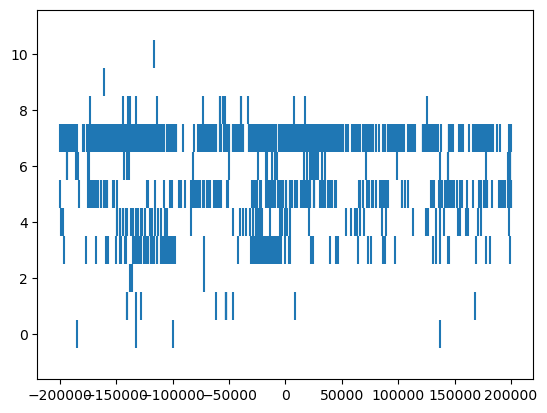

In [78]:
plt.eventplot(example_df["relative_time_to_tone"])

In [ ]:
# Getting a list of all the trials for each recording
recording_to_neuron_to_trial_timestamp = defaultdict(dict)
# Loop through each unique key
for key in merged_spike_trial_df['recording_file'].unique():
    # Filter the DataFrame based on the key and get the 'Value' column as a list
    recording_to_trials[key] = all_trials_df[all_trials_df['recording_file'] == key]['time'].tolist()


In [ ]:
merged_spike_trial_df

In [57]:
raise ValueError()

ValueError: 

In [ ]:
merged_spike_trial_df.head()

In [ ]:
plt.eventplot()

In [ ]:
merged_spike_trial_df["recording_file"]
merged_spike_trial_df[""]

In [ ]:
raise ValueError()

In [ ]:
merged_spike_trial_df = pd.merge(left=all_spike_time_df, right=all_trials_df, left_on="recording_name", right_on="recording_file", how="left")

In [ ]:
all_trials_df

In [ ]:
spike_times

In [ ]:
spike_clusters

In [ ]:
spike_df

In [ ]:
spike_clusters

In [ ]:
recording_to_spike_df[list(recording_to_spike_df.keys())[0]].head()

In [ ]:
list(recording_to_spike_df.keys())[0]

In [ ]:
current_df = recording_to_spike_df[list(recording_to_spike_df.keys())[0]]

In [ ]:
current_df = current_df[current_df["spike_clusters"]==9]

In [ ]:
epsilon = 1e-10


In [ ]:
current_df["current_isi"] = current_df["current_isi"] + epsilon

In [ ]:
bins = np.linspace(0, 0.01, num=11)

In [ ]:
bins

In [ ]:
sns.histplot(current_df["current_isi"], bins=bins)


In [ ]:
recording_to_spike_df[list(recording_to_spike_df.keys())[0]].tail()

In [ ]:
current_df["cluster_id"].unique()

In [ ]:
bins = np.linspace(0, 0.05, num=51)

In [ ]:
current_df = recording_to_spike_df[list(recording_to_spike_df.keys())[0]]
for id in sorted(current_df["cluster_id"].unique()):
    try:
        unit_df = current_df[current_df["spike_clusters"]==id]
        n_spikes = unit_df["n_spikes"].iloc[0]
        counts, bin_edges = np.histogram(unit_df["current_isi"], bins=bins)
        # print(counts)
        # if counts[0] + counts[1] <= n_spikes / 1000:
        fig, ax = plt.subplots()
        sns.histplot(unit_df["current_isi"], bins=bin_edges, kde=False)        
        plt.title("Unit {} with {} spikes and {} + {} in ISI bars at {} {} ISI Ratio".format(id, n_spikes, counts[0], counts[1], round(counts[0]/ n_spikes * 1000, 4), round(counts[1] / n_spikes * 1000, 4)))
        plt.show()
        plt.close()
    except Exception as e: 
        print(e)        
        continue
    

In [ ]:
raise ValueError()

# Labeling before or after

In [ ]:
recording_to_spike_df.keys()

In [ ]:
all_trials_df = all_trials_df[all_trials_df["recording_file"].isin(recording_to_spike_df.keys())].reset_index(drop=True)

In [ ]:
all_trials_df.head()

# Calculating the firing rate

In [ ]:
all_trials_df.columns

In [ ]:
all_trials_df.head()

In [ ]:
grouped_trials_df = all_trials_df.groupby(["recording_file", "current_subject", "video_number"]).agg({
    'time_stamp_index': list,
    'trial_outcome': list,
    'competition_closeness': list}).reset_index()

In [ ]:
grouped_trials_df.head()

In [ ]:
grouped_trials_df = grouped_trials_df.drop_duplicates(subset=["recording_file", "current_subject"], keep='first').reset_index(drop=True)

In [ ]:
grouped_trials_df.head()

## Seeing which tone time each unit time is closest to

- We will divide all the time up into bins of before and after each tone. Then we will see which time bin the neuron firing falls into.
    - So everything in the 0 bin would be before the first time bin. The 1 bin would be everything in between the first and second time bin. The last would be everything after last time bin.

In [ ]:
recording_to_spike_df[list(recording_to_spike_df.keys())[0]].head()

In [ ]:
def find_closest(num, ordered_list):
    # Using a list comprehension to find the differences and then return the number with the smallest difference
    return min(ordered_list, key=lambda x: abs(x - num))

In [ ]:
for recording, spike_df in recording_to_spike_df.items():
    try:
        current_recording = grouped_trials_df[grouped_trials_df["recording_file"] == recording].iloc[0]
        current_time_stamps = current_recording["time_stamp_index"]
        spike_df["closest_timestamp"] = spike_df["spike_times"].apply(lambda x: find_closest(x, current_time_stamps))
        spike_df["timestamp_difference"] = spike_df["spike_times"] - spike_df["closest_timestamp"] 
        
    except Exception as e:
        print(e)
        continue

In [ ]:
len(current_time_stamps)

In [ ]:
spike_df

- Seeing if the firing time is within a 5 second interval before or 10 second after any tone

In [ ]:
grouped_trials_df["good_unit_times"].iloc[0][0][0]

In [ ]:
from collections import defaultdict

In [ ]:
def within_interval(row):
    """
    """
    within_interval_unit_times = defaultdict(list)
    for index, time in enumerate(row['good_unit_times']):
        current_bin = row['good_unit_bins'][index]

        try:
            # checking number before
            first_tone_time = row['time_stamp_index'][current_bin - 1]
            if time >= first_tone_time - 5 * 20000 and time <= first_tone_time + 10 * 20000:
                within_interval_unit_times[first_tone_time].append(
                    (first_tone_time, index, time, row['good_unit_all_ids']))
    
            # checking number after
            second_tone_time = row['time_stamp_index'][current_bin]
            if time >= second_tone_time - 5 * 20000 and time <= second_tone_time + 10 * 20000:
                within_interval_unit_times[second_tone_time].append(
                    (second_tone_time, index, time, row['good_unit_all_ids']))
        except:
            pass
    
    return within_interval_unit_times



In [ ]:
grouped_trials_df["within_interval"] = grouped_trials_df.apply(within_interval, axis=1)

In [ ]:
grouped_trials_df["within_interval"].iloc[1]

In [ ]:
within_interval_unit_times = defaultdict(list)
for index, time in enumerate(good_unit_times):
    try:
        current_bin = good_unit_bins[index]


        # checking number before
        first_tone_time = training_and_competition_trials[current_bin - 1]
        if time >= first_tone_time - 5 * 20000 and time <= first_tone_time + 10 * 20000:
            within_interval_unit_times[first_tone_time].append((first_tone_time, index, time, good_unit_all_ids[index]))

        # checking number after
        second_tone_time = training_and_competition_trials[current_bin]
        if time >= second_tone_time - 5 * 20000 and time <= second_tone_time + 10 * 20000:
            within_interval_unit_times[second_tone_time].append((second_tone_time, index, time, good_unit_all_ids[index]))
    except:
        pass

In [ ]:
within_interval_unit_times[training_and_competition_trials[0]][:10]

In [ ]:
within_interval_unit_times[training_and_competition_trials[-1]][:10]

## Seeing which 100ms bin each unit time belongs to

- Creating bins for each 100ms time interval

In [ ]:
tone_unit_time_to_interval = {}
for time in training_and_competition_trials:
    tone_unit_time_to_interval[time] = [time + num * 2000 for num in range(-50, 100)]

In [ ]:
len(tone_unit_time_to_interval[training_and_competition_trials[0]])

- Seeing which bin the tone time fits into

In [ ]:
all_bin_mapping = None
for key, value in within_interval_unit_times.items():
    unit_fire_time = [fire_time for tone_time, index, fire_time, unit_id in value]
    unit_fire_bin = np.digitize(unit_fire_time, tone_unit_time_to_interval[key], right=True)
    current_tone_bin_map = np.hstack((np.array(value), unit_fire_bin[np.newaxis].T))
    if all_bin_mapping is None:
        all_bin_mapping = current_tone_bin_map
    else: 
        all_bin_mapping = np.vstack((all_bin_mapping, current_tone_bin_map))
    

In [ ]:
all_bin_mapping

## Calculating Firing Rate

In [ ]:
from collections import Counter, defaultdict

- Creating a reference for all the tone bin combinations to each tone
    - This is because we need a unique identifier for each tone and bin combination. So we will just add the numbers

In [ ]:
tone_bin_for_index = all_bin_mapping[:,0] + all_bin_mapping[:,4]

In [ ]:
tone_bin_to_tone = np.hstack((tone_bin_for_index[np.newaxis].T, all_bin_mapping[:,0][np.newaxis].T))

In [ ]:
tone_bin_to_tone

In [ ]:
tone_bin_to_tone = dict(zip(tone_bin_to_tone[:,0], tone_bin_to_tone[:,1]))

In [ ]:
tone_bin_to_tone

In [ ]:
tone_bin_for_index

- Getting the number of times each neuron fires

In [ ]:
firing_counts = defaultdict(lambda: defaultdict(dict))
for tone_time, index, firing_time, unit_id, bin_index in all_bin_mapping:
    tone_bin = tone_time + bin_index
    if firing_counts[unit_id][tone_bin]:
        firing_counts[unit_id][tone_bin] += 1
    else:
        firing_counts[unit_id][tone_bin] = 1

In [ ]:
firing_rate_df = pd.DataFrame.from_dict(firing_counts)

In [ ]:
firing_rate_df = firing_rate_df.fillna(value=0)

In [ ]:
firing_rate_df.head()

In [ ]:
firing_rate_df.loc[:].values

- Classifying each time stamp

In [ ]:
all_bin_mapping

In [ ]:
all_bin_mapping[:, 0]

In [ ]:
all_bin_mapping[:, 2]

- Making a dictionary that maps all the firing times to the corresponding tone

In [ ]:
fire_to_tone_time = dict(zip(all_bin_mapping[:, 2], all_bin_mapping[:, 0]))

In [ ]:
fire_to_tone_time

In [ ]:
firing_rate_df = firing_rate_df.reset_index()

- Labeling which tone time that fire time belongs to

In [ ]:
firing_rate_df["tone_time"] = firing_rate_df["index"].map(tone_bin_to_tone)

In [ ]:
firing_rate_df.head()

In [ ]:
firing_rate_df["bin"] = firing_rate_df["index"] - firing_rate_df["tone_time"]

In [ ]:
training_and_competition_trials

In [ ]:
len(training_and_competition_trials)

In [ ]:
# iterating through the timestamp of each good unit spike

before_and_after_interval_unit_times = defaultdict(dict)

per_trial_number_of_samples = trial_one_way_duration * sampling_rate

for index, time in enumerate(good_unit_times):
    # getting the corresponding tone bin for the timestamp
    current_bin = good_unit_bins[index]
    current_neuron = good_unit_all_ids[index]   
    
    # checking number before
    first_tone_time = tone_time_stamps[(current_bin - 1) % len(tone_time_stamps)]
    # checking number after
    second_tone_time = tone_time_stamps[(current_bin) % len(tone_time_stamps)]    
    
    # checking if time is before first number
    if first_tone_time - per_trial_number_of_samples <= time <= first_tone_time:
        before_and_after_interval_unit_times[time]["tone_time"] = first_tone_time
        before_and_after_interval_unit_times[time]["before_or_after"] = "before"
        before_and_after_interval_unit_times[time]["neuron_id"] = good_unit_all_ids[index]
    # checking if time is after first number
    elif first_tone_time < time <= first_tone_time + per_trial_number_of_samples:
        before_and_after_interval_unit_times[time]["tone_time"] = first_tone_time
        before_and_after_interval_unit_times[time]["before_or_after"] = "after"
        before_and_after_interval_unit_times[time]["neuron_id"] = good_unit_all_ids[index]
    # checking if time is before second number
    if second_tone_time - per_trial_number_of_samples <= time <= second_tone_time:
        before_and_after_interval_unit_times[time]["tone_time"] = second_tone_time
        before_and_after_interval_unit_times[time]["before_or_after"] = "before"
        before_and_after_interval_unit_times[time]["neuron_id"] = good_unit_all_ids[index]
    # checking if time is after second number
    elif second_tone_time < time <= second_tone_time + per_trial_number_of_samples:
        before_and_after_interval_unit_times[time]["tone_time"] = second_tone_time
        before_and_after_interval_unit_times[time]["before_or_after"] = "after"
        before_and_after_interval_unit_times[time]["neuron_id"] = good_unit_all_ids[index]

In [ ]:
recording_to_good_unit_times

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=a4490980-3f6a-4f44-80eb-ebd789a5b21f' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>